In [112]:
import os
os.chdir("..")

# Import Files

In [113]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from scipy.stats import norm
from joblib import Parallel, delayed

from src.yahoo_finance import *

In [114]:
class GaussianMAR:
    def __init__(self, data:pd.Series, n_components:int, phi_orders:list[int], tol:float=1e-6, max_iter:int=200, 
                 alpha:np.ndarray[float]=None, sigma:np.ndarray[float]=None, phi:list[np.ndarray[float]]=None, seed:int=None):
        
        if n_components != len(phi_orders):
            raise ValueError(f"Number of components must match the number of phi_orders.")
        
        self.y = data.to_numpy()
        self.n = len(self.y)
        self.n_components = n_components
        self.phi_orders = phi_orders
        
        self.tol = tol
        self.max_iter = max_iter
        
        self.rng = np.random.default_rng(seed)
        self.params = {
            'alpha': alpha,
            'sigma': sigma,
            'phi': phi
        }
        self.initial_guess()
        
        self.min_timestep = max(phi_orders)
        self.train_n = len(self.y) #for AIC/BIC calculation
    
    def initial_guess(self):
        if self.params['alpha'] is None:
            self.params['alpha'] = np.ones(self.n_components)/ self.n_components #must sum to 1
        
        if self.params['sigma'] is None:
            self.params['sigma'] = np.ones(self.n_components)
        
        if self.params['phi'] is None:
            self.params['phi'] = [self.rng.standard_normal(order+1) for order in self.phi_orders] #Account for order 0 (the intercept)
    
    def _reverse_index(self, x:np.ndarray, from_pt:int, to_pt:int) -> np.ndarray:
        if to_pt == 0:
            return x[from_pt::-1]
        
        return x[from_pt:to_pt-1:-1]
    
    def e_step(self, y:np.ndarray, alpha:np.ndarray, sigma:np.ndarray, phi:list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:        
        tau = np.zeros(shape=(self.n, self.n_components))
        epsilon = tau.copy()
        for t in range(self.min_timestep, self.n):
            for k in range(self.n_components):
                p = phi[k]
                start_pt = t - self.phi_orders[k]
                y_lags = np.array([1] + self._reverse_index(y, t-1, start_pt).tolist()) #1 for phi_0, and remaining is in reversed order to get t-1, t-2 ..., t-n
                eps = y[t] - p.T@y_lags
                
                numerator = (alpha[k]/sigma[k])* norm.pdf(eps/ sigma[k])
                
                epsilon[t, k] = eps
                tau[t, k] = numerator
            
            tau[t, :] /= np.sum(tau[t, :]) #normalize to sum to 1
        
        return epsilon, tau #(timesteps, n_components)
    
    def log_likelihood(self, alpha:np.ndarray[float], sigma:np.ndarray[float], epsilon:np.ndarray) -> float:
        filtered_epsilon = epsilon[self.min_timestep:]
        component_densities = (alpha/sigma)* np.exp(-(filtered_epsilon**2)/ (2*sigma**2))
        mixture_density = np.sum(component_densities, axis=1) #sum columns
        return np.sum(np.log(mixture_density))
    
    def _maximize_alpha(self, tau_k:np.ndarray, phi_order_k:int) -> float:
        filtered_tau = tau_k[phi_order_k+1:]
        numerator = np.sum(filtered_tau)
        denominator = self.n-phi_order_k
        return numerator/denominator
    
    def _maximize_sigma(self, tau_k:np.ndarray, epsilon_k:np.ndarray, phi_order_k:int) -> float:
        filtered_tau = tau_k[phi_order_k+1:]
        filtered_epsilon = epsilon_k[phi_order_k+1:]
        numerator = np.sum(filtered_tau* filtered_epsilon**2)
        denominator = np.sum(tau_k)
        return np.sqrt(numerator/denominator)
    
    def _maximize_phi(self, y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
        W = np.diag(tau_k[phi_order_k:])
        Y = y[phi_order_k:]
        
        y_lags = [y[phi_order_k-p-1: self.n-p-1] for p in range(phi_order_k)] #(p, n-p)
        X = np.column_stack([np.ones(self.n-phi_order_k)] + y_lags) #(n-p, p+1)
        
        XT_W = X.T @ W
        A = XT_W @  X
        b = XT_W @ Y
    
        return np.linalg.solve(A, b) #More stable than finding the inverse
    
    def m_step(self, tau:np.ndarray, epsilon:np.ndarray) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        alpha, sigma, phi = [], [], []
        for k in range(self.n_components):
            alpha_hat = self._maximize_alpha(tau_k=tau[:, k], phi_order_k=self.phi_orders[k])
            sigma_hat = self._maximize_sigma(tau_k=tau[:, k], epsilon_k=epsilon[:, k], phi_order_k=self.phi_orders[k])
            phi_hat = self._maximize_phi(y=self.y, tau_k=tau[:, k], phi_order_k=self.phi_orders[k])
            
            alpha.append(alpha_hat)
            sigma.append(sigma_hat)
            phi.append(phi_hat)
        
        params = {
            'alpha': np.array(alpha),
            'sigma': np.array(sigma),
            'phi': phi
        }
        return params
    
    def fit(self) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        self.log_likelihood_vals = []
        curr_log_likelihood = 0
        for i in range(self.max_iter):
            epsilon, self.tau = self.e_step(self.y, **self.params)
            
            old_log_likelihood = curr_log_likelihood
            curr_log_likelihood = self.log_likelihood(self.params['alpha'], self.params['sigma'], epsilon)
            self.log_likelihood_vals.append(curr_log_likelihood)
            if np.abs(curr_log_likelihood - old_log_likelihood) <= self.tol:
                print("Parameters have converged.")
                return self.params
            
            self.params = self.m_step(tau=self.tau, epsilon=epsilon)
        
        print("Max iteration has been reached.")
        return self.params
    
    @property
    def fitted_values(self):
        col_names = [str(f"cluster_{k}") for k in range(self.n_components)]
        df = pd.DataFrame(self.tau, columns=col_names)
        return df
    
    def greedy_assignment(self, tau:np.ndarray) -> pd.Series:
        col_names = [str(f"cluster_{k}") for k in range(self.n_components)]
        df = pd.DataFrame(tau, columns=col_names)
        labels = df.idxmax(axis=1).str[-1].astype(int)
        labels = labels.where(df.nunique(axis=1) > 1, -1)
        return labels
    
    def predict(self, y:float|list|np.ndarray|pd.Series, update_history:bool=False) -> np.ndarray:
        new_y = np.asarray(y).reshape(-1) #1D array
        n = len(new_y)
        tau = np.zeros((n, self.n_components))
        
        for t in range(n):
            for k in range(self.n_components):
                p = self.params['phi'][k]
                phi_order = self.phi_orders[k]
                
                if phi_order == 0:
                    y_lags = np.array([1])
                elif phi_order > 0:
                    y_lags = self.y[-phi_order:]
                    y_lags = np.array([1] + y_lags[::-1].tolist())
                eps = new_y[t] - p.T @ y_lags
                
                alpha = self.params['alpha'][k]
                sigma = self.params['sigma'][k]
                numerator = (alpha/sigma)* norm.pdf(eps/sigma)
                tau[t, k] = numerator
            
            tau[t, :] /= np.sum(tau[t, :])
        
        if update_history:
            self.update_history(y)
        
        return tau
    
    def update_history(self, y:float|list|np.ndarray|pd.Series):
        new_y = np.asarray(y).reshape(-1)
        self.y = np.append(self.y, new_y)
        self.n = len(self.y)
    
    @property
    def aic(self):
        val = -2*self.log_likelihood_vals[-1] +\
            2*(3*self.n_components - 1 + np.sum(self.phi_orders))
        return val
    
    @property
    def bic(self):
        val = -2*self.log_likelihood_vals[-1] +\
            np.log(self.train_n - self.min_timestep) *\
            (3*self.n_components - 1 + np.sum(self.phi_orders))
        return val

# Price Data and Fit Model

In [115]:
params = {
    'symbol': 'IBM',
    'start_date': '1962-01-02',
    'end_date': '1963-05-01',
    'interval': '1d'
}
yf = YahooFinance(**params)
df = yf.pipeline()
df['first_diff'] = df['adj_close'].diff(1)
df = df.dropna().reset_index(drop=True)
df.head(5)

[*********************100%***********************]  1 of 1 completed


,date,adj_close,log_return,first_diff
0,1962-01-03,1.476464,0.008704,0.012795
1,1962-01-04,1.461751,-0.010016,-0.014714
2,1962-01-05,1.432963,-0.019890,-0.028787
3,1962-01-08,1.406096,-0.018928,-0.026868
4,1962-01-09,1.422728,0.011760,0.016633


In [116]:
print(len(df))

334


In [117]:
seed=42
n_components=3
phi_orders=[1,1,0]

For reference, we see that that the total time taken is about 6 to 12 seconds for a sample size of 334. We believe that there are many areas of improvement in this algorithm, through the use of smarter loops and parallelization.

In [118]:
mar = GaussianMAR(df['first_diff'], n_components=n_components, phi_orders=phi_orders, seed=seed)
mar.fit()

Parameters have converged.


{'alpha': array([0.58231626, 0.38135482, 0.03327615]),
 'sigma': array([0.01203259, 0.01506223, 0.04825814]),
 'phi': [array([ 0.00255706, -0.35368583]),
  array([-0.00544544,  0.63884696]),
  array([-0.01328641])]}

# Remove Diagonalization

A diagonal matrix essentially have values on the diagonal and 0 everywhere else. Computation-wise, this is wasteful as all we want is essentially a weighted vector, which can be achieved through element-wise multiplication.

In [119]:
class OptimizedMAR(GaussianMAR):
    def __init__(self, data:pd.Series, n_components:int, phi_orders:list[int], tol:float=1e-6, max_iter:int=200, 
                alpha:np.ndarray[float]=None, sigma:np.ndarray[float]=None, phi:list[np.ndarray[float]]=None, seed:int=None):
        super().__init__(data, n_components, phi_orders, tol, max_iter, alpha, sigma, phi, seed)
    
    def _maximize_phi(self, y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
        W = tau_k[phi_order_k:] #(n-p, )
        Y = y[phi_order_k:] #(n-p, )
        
        y_lags = [y[phi_order_k-p-1: self.n-p-1] for p in range(phi_order_k)] #(p, n-p)
        X = np.column_stack([np.ones(self.n-phi_order_k)] + y_lags) #(n-p, p+1)
        
        A = X.T @ (X*W.reshape(-1, 1))
        b = X.T @ (W*Y)
    
        return np.linalg.solve(A, b) #More stable than finding the inverse

In [120]:
optimized_mar = OptimizedMAR(df['first_diff'], n_components=n_components, phi_orders=phi_orders, seed=seed)
optimized_mar.fit()

Parameters have converged.


{'alpha': array([0.58231626, 0.38135482, 0.03327615]),
 'sigma': array([0.01203259, 0.01506223, 0.04825814]),
 'phi': [array([ 0.00255706, -0.35368583]),
  array([-0.00544544,  0.63884696]),
  array([-0.01328641])]}

# Parallelization

In order to speed up the process, we will use parallelization. However, one must be careful when implementing this.

Below are best practices:
- Do not use any bound methods like "self." in the worker function, as joblib will pickle the full copy of the class instance. This will backfire and make your algorithm slower, instead of faster.
- Unless you are really sure, I suggest using n_jobs = -2 instead of -1 as the extra CPU acts as a safety mechanism against potential accidents.
- Do not create a Parallel instance inside a loop as this forces joblib to create and destroy the workers at each iteration, which will make your algorithm slower.

In our case, the worker function is "_m_step_components()". Moreover, instead of creating a Parallel instance in every m_step, we will create the instance once in "fit()" and that instance into the "m_step()" 

Source: https://joblib.readthedocs.io/en/latest/parallel.html#parallel

In [121]:
class ParallelMAR(GaussianMAR):
    def __init__(self, data:pd.Series, n_components:int, phi_orders:list[int], tol:float=1e-6, max_iter:int=200, 
                 alpha:np.ndarray[float]=None, sigma:np.ndarray[float]=None, phi:list[np.ndarray[float]]=None, seed:int=None):
        super().__init__(data, n_components, phi_orders, tol, max_iter, alpha, sigma, phi, seed)
    
    def m_step(self, tau:np.ndarray, epsilon:np.ndarray, parallel:Parallel) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        def _maximize_alpha(n:int, tau_k:np.ndarray, phi_order_k:int) -> float:
            filtered_tau = tau_k[phi_order_k+1:]
            numerator = np.sum(filtered_tau)
            denominator = n-phi_order_k
            return numerator/denominator
    
        def _maximize_sigma(tau_k:np.ndarray, epsilon_k:np.ndarray, phi_order_k:int) -> float:
            filtered_tau = tau_k[phi_order_k+1:]
            filtered_epsilon = epsilon_k[phi_order_k+1:]
            numerator = np.sum(filtered_tau* filtered_epsilon**2)
            denominator = np.sum(tau_k)
            return np.sqrt(numerator/denominator)
        
        def _maximize_phi(n:int, y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
            W = tau_k[phi_order_k:]
            Y = y[phi_order_k:]
            
            y_lags = [y[phi_order_k-p-1: n-p-1] for p in range(phi_order_k)] #(p, n-p)
            X = np.column_stack([np.ones(n-phi_order_k)] + y_lags) #(n-p, p+1)
            
            A = X.T @ (X*W.reshape(-1, 1))
            b = X.T @ (W*Y)
        
            return np.linalg.solve(A, b) #More stable than finding the inverse
       
        def _m_step_components(y:np.ndarray, n:int, phi_order:np.ndarray, tau:np.ndarray, epsilon:np.ndarray) -> tuple[float, float, np.ndarray]:
            alpha_hat = _maximize_alpha(n=n, tau_k=tau, phi_order_k=phi_order)
            sigma_hat = _maximize_sigma(tau_k=tau, epsilon_k=epsilon, phi_order_k=phi_order)
            phi_hat = _maximize_phi(n=n, y=y, tau_k=tau, phi_order_k=phi_order)
            return alpha_hat, sigma_hat, phi_hat
        
        results = parallel(
            delayed(_m_step_components)(self.y, self.n, self.phi_orders[k], tau[:, k], epsilon[:, k])
            for k in range(self.n_components)
        )
        
        alpha, sigma, phi = zip(*results)
        params = {
            'alpha': np.array(alpha),
            'sigma': np.array(sigma),
            'phi': phi
        }
        return params
    
    def fit(self) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        self.log_likelihood_vals = []
        curr_log_likelihood = 0
        with Parallel(n_jobs=-2) as parallel:
            for i in range(self.max_iter):
                epsilon, self.tau = self.e_step(self.y, **self.params)
                
                old_log_likelihood = curr_log_likelihood
                curr_log_likelihood = self.log_likelihood(self.params['alpha'], self.params['sigma'], epsilon)
                self.log_likelihood_vals.append(curr_log_likelihood)
                if np.abs(curr_log_likelihood - old_log_likelihood) <= self.tol:
                    print("Parameters have converged.")
                    return self.params
                
                self.params = self.m_step(tau=self.tau, epsilon=epsilon, parallel=parallel)
        
        print("Max iteration has been reached.")
        return self.params

After experimenting with parallelizing the M-Step, it is evident that the parallel version is slower than the sequential implementation. This is likely due to the parallelization overhead dominating the actual computation.

One likely cause is that the M-step is parallelized over the n_components, which is typically small at around 2 to 5. This is considered a small task and hence the whole process of spawning workers, scheduling and collecting results exceeds the runtime of the computations.

However, if the n_components is large, then perhaps this would be more efficient. Nonetheless, the chance of having more than 5 regimes is unlikely, let alone 100 regimes. Therefore, we will not be implementing parallelization in the final version.

In [122]:
parallel_mar = ParallelMAR(df['first_diff'], n_components=n_components, phi_orders=phi_orders, seed=seed)
parallel_mar.fit()

Parameters have converged.


{'alpha': array([0.58231626, 0.38135482, 0.03327615]),
 'sigma': array([0.01203259, 0.01506223, 0.04825814]),
 'phi': (array([ 0.00255706, -0.35368583]),
  array([-0.00544544,  0.63884696]),
  array([-0.01328641]))}

# Numba
Numba is a just-in-time (JIT) compiler that translates a subset of Python and NumPy code into optimized machine code. It is particularly effective for numerical oriented algorithms with a lot of NumPy and loops.

Implementation is simple as we just need to include the decorator "@jit" or "@njit" above our numerical function. However, if we are using any non-numerical functions like "scipy.norm.pdf()", "@jit" would be preferred as it uses Python as a fallback. Notably, we should always try to use "@njit" to ensure maximum efficiency, hence we will convert "scipy.norm.pdf()" to the mathematical formula. 

Source: https://numba.readthedocs.io/en/stable/user/5minguide.html

In [123]:
@njit
def e_step(y, alpha, sigma, phi, phi_orders, min_timestep):
    n = len(y)
    n_components = len(alpha)
    tau = np.zeros((n,n_components))
    epsilon = tau.copy()

    for t in range(min_timestep, n):
        denom = 0.0 # Sum denominator as we go instead of at the end
        for k in range(n_components):
            # Add the AR lags sequentially
            order = phi_orders[k]
            ar_y_lags = phi[k][0] #Intercept: phi_0
            for p in range(order):
                ar_y_lags += phi[k][p+1] * y[t-1-p]
            
            eps = y[t] - ar_y_lags
            epsilon[t, k] = eps
            num = (alpha[k]/sigma[k]) * np.exp(-0.5*(eps/sigma[k])**2) #Excluded constant (does not contribute information)
            tau[t, k] = num
            denom += num
        
        # Normalize to sum to 1
        for k in range(n_components):
            tau[t, k] /= denom

    return epsilon, tau #(timesteps, n_components)

class OptimizedMAR(GaussianMAR):
    def __init__(self, data:pd.Series, n_components:int, phi_orders:list[int], tol:float=1e-6, max_iter:int=200, 
                alpha:np.ndarray[float]=None, sigma:np.ndarray[float]=None, phi:list[np.ndarray[float]]=None, seed:int=None, quiet:bool=False):
        super().__init__(data, n_components, phi_orders, tol, max_iter, alpha, sigma, phi, seed)
        self.quiet = quiet
    
    def _maximize_phi(self, y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
        W = tau_k[phi_order_k:]
        Y = y[phi_order_k:]
        
        y_lags = [y[phi_order_k-p-1: self.n-p-1] for p in range(phi_order_k)] #(p, n-p)
        X = np.column_stack([np.ones(self.n-phi_order_k)] + y_lags) #(n-p, p+1)
        
        A = X.T @ (X*W.reshape(-1, 1))
        b = X.T @ (W*Y)
    
        return np.linalg.solve(A, b) #More stable than finding the inverse
    
    def fit(self) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        self.log_likelihood_vals = []
        curr_log_likelihood = 0
        for i in range(self.max_iter):
            epsilon, self.tau = e_step(self.y, phi_orders=self.phi_orders, min_timestep=self.min_timestep, **self.params)
            
            old_log_likelihood = curr_log_likelihood
            curr_log_likelihood = self.log_likelihood(self.params['alpha'], self.params['sigma'], epsilon)
            self.log_likelihood_vals.append(curr_log_likelihood)
            if np.abs(curr_log_likelihood - old_log_likelihood) <= self.tol:
                if self.quiet is False: print("Parameters have converged.")
                return self.params
            
            self.params = self.m_step(tau=self.tau, epsilon=epsilon)
        
        if self.quiet is False: print("Max iteration has been reached.")
        return self.params

Here we see a substantial improvement in run time. Therefore, we will include this into the finalized version.

In [124]:
numba_mar = OptimizedMAR(df['first_diff'], n_components=n_components, phi_orders=phi_orders, seed=seed)
numba_mar.fit()

Parameters have converged.


{'alpha': array([0.58231626, 0.38135482, 0.03327615]),
 'sigma': array([0.01203259, 0.01506223, 0.04825814]),
 'phi': [array([ 0.00255706, -0.35368583]),
  array([-0.00544544,  0.63884696]),
  array([-0.01328641])]}

# Experimentation with S&P500

In [125]:
params = {
    'symbol': 'SPY',
    'start_date': '1962-01-02',
    'end_date': '2019-12-31',
    'interval': '1d'
}
yf = YahooFinance(**params)
snp_df = yf.pipeline()
snp_df['first_diff'] = snp_df['adj_close'].diff(1)
snp_df = snp_df.dropna().reset_index(drop=True)
snp_df.head(5)

[*********************100%***********************]  1 of 1 completed


,date,adj_close,log_return,first_diff
0,1993-02-01,24.485958,0.007087,0.172924
1,1993-02-02,24.537827,0.002116,0.051868
2,1993-02-03,24.797228,0.010516,0.259401
3,1993-02-04,24.900974,0.004175,0.103746
4,1993-02-05,24.883688,-0.000694,-0.017286


Even though we have a few decades worth of data, the processing time is in the milliseconds. This is quite impressive and no further improvement is required in terms of efficiency.

In [126]:
snp_mar = OptimizedMAR(snp_df['first_diff'], n_components=n_components, phi_orders=phi_orders, seed=seed, max_iter=500)
snp_mar.fit()

Parameters have converged.


{'alpha': array([0.60479851, 0.29169182, 0.10334988]),
 'sigma': array([0.9674662 , 0.23601798, 2.64222816]),
 'phi': [array([ 0.087774  , -0.05737874]),
  array([ 0.06097379, -0.05313513]),
  array([-0.2695177])]}

In [127]:
snp_df['mar_cluster'] = snp_mar.greedy_assignment(snp_mar.tau)
snp_df.head(5)

,date,adj_close,log_return,first_diff,mar_cluster
0,1993-02-01,24.485958,0.007087,0.172924,-1
1,1993-02-02,24.537827,0.002116,0.051868,1
2,1993-02-03,24.797228,0.010516,0.259401,1
3,1993-02-04,24.900974,0.004175,0.103746,1
4,1993-02-05,24.883688,-0.000694,-0.017286,1


In [128]:
def plot_cluster_charts(df:pd.DataFrame, n_components:int, label_col_name:str):
    fig, axes= plt.subplots(ncols=3, figsize=(20,5))
    colors = sns.color_palette("colorblind", n_components)
    grps = []
    
    axes[0].set_title("Adjusted Close Time Series")
    axes[0].plot(df['adj_close'], color='gray', linestyle='--')
    for i in range(n_components):
        grp = df.copy()
        grp.loc[grp[label_col_name] != i] = np.nan 
        axes[0].plot(grp['adj_close'], color=colors[i], label=f'Cluster {i}') 
        grps.append(grp)
    axes[0].legend()
    
    axes[1].set_title('FIrst-Differenced Adjusted Close Time Series')
    axes[1].plot(df['first_diff'], color='gray', linestyle='--')
    for i in range(n_components):
        df = grps[i].copy()
        axes[1].plot(df['first_diff'], color=colors[i], label=f'Cluster {i}', alpha=0.5) 
    axes[1].legend()
    
    axes[2].set_title('Distribution of Adjusted Close')
    for i in range(n_components):
        df = grps[i].copy().dropna()
        axes[2].hist(df['adj_close'], alpha=0.5, label=f'Cluster {i}', density=True, color=colors[i])
    axes[2].legend()
    
    return fig

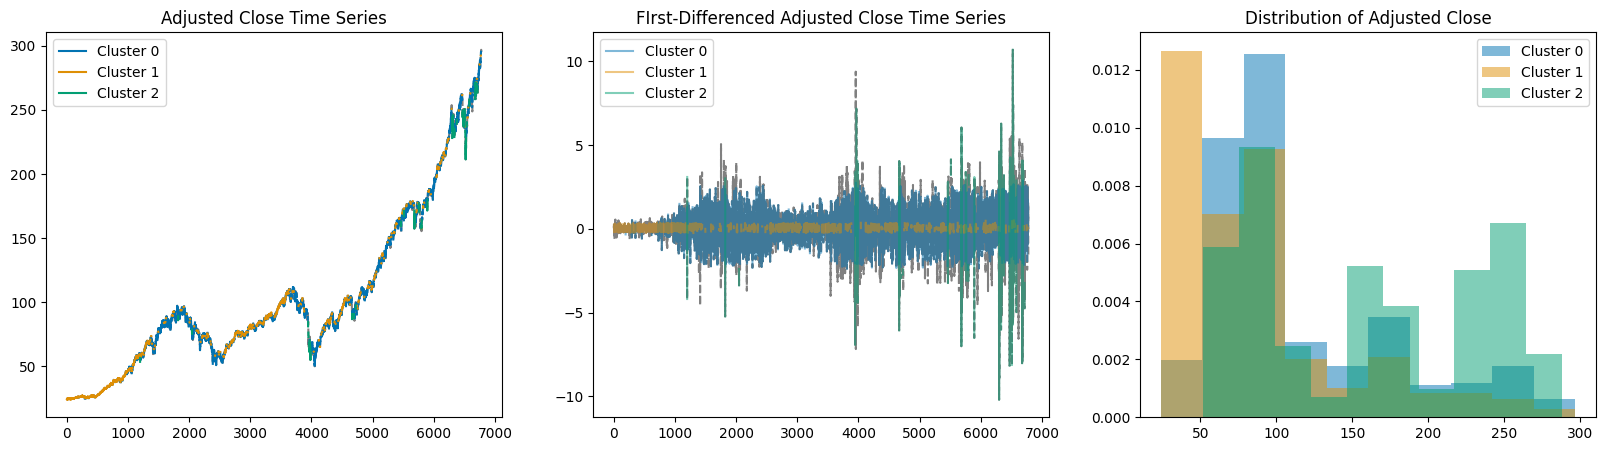

In [129]:
fig = plot_cluster_charts(snp_df, n_components, 'mar_cluster')
plt.show()

# Grid Search

In [130]:
def grid_search(data:pd.Series, max_components:int, max_ar:int, tol:float=1e6, max_iter:int=200, seed:int=None, quiet:bool=True) -> pd.DataFrame:
    min_components = 2
    if max_components < min_components:
        raise ValueError("Number of components must be at least 2.")
    
    results = []
    for n_components in range(min_components, max_components+1):
        ar_orders = list(itertools.product(range(max_ar+1), repeat=n_components))
        
        for phi_orders in ar_orders:
            params={
                'data': data,
                'n_components': n_components,
                'phi_orders': phi_orders,
                'tol': tol,
                'max_iter': max_iter,
                'seed': seed,
                'quiet': quiet
            }
            
            model = OptimizedMAR(**params)
            model.fit()
        
            entry = {
                "n_components": n_components,
                "phi_orders": phi_orders,
                "log_likelihood": model.log_likelihood_vals[-1],
                "aic": model.aic,
                "bic": model.bic
            }
            
            results.append(entry)
    
    return pd.DataFrame(results)

In [131]:
grid_result = grid_search(snp_df['first_diff'], max_components=5, max_ar=5, max_iter=500, seed=seed)
grid_result.head(5)

,n_components,phi_orders,log_likelihood,aic,bic
0,2,"(0, 0)",-4959.519104,9929.038207,9963.145394
1,2,"(0, 1)",-4967.662485,9947.324969,9988.252708
2,2,"(0, 2)",-5091.376494,10196.752987,10244.500983
3,2,"(0, 3)",-6110.260120,12236.520240,12291.088198
4,2,"(0, 4)",-6345.466454,12708.932908,12770.320531


## Analysis of Best Parameters
In terms of the BIC, we see that the "best" parameters found by the grid search is significantly better than the original selection. However, this could be misleading as adding more components over-complicates the fitted model and may not meaningfully segregate the clusters appropriately. 

In [132]:
def get_best_params(grid_result:pd.DataFrame, criteria:str='bic') -> dict[int, tuple[int]]:
    col_names = grid_result.columns[2:]
    if criteria not in col_names:
        raise ValueError(f"Criteria must be one of the following: {list(col_names)}")
    
    best_idx = grid_result[criteria].idxmax() if criteria == 'log_likelihood' else grid_result[criteria].idxmin()
    params = {
        'n_components': grid_result.loc[best_idx, 'n_components'],
        'phi_orders': grid_result.loc[best_idx, 'phi_orders']
    }
    return params

In [133]:
best_params = get_best_params(grid_result, criteria='bic')
best_params['seed'] = seed
print(best_params)

{'n_components': np.int64(5), 'phi_orders': (0, 1, 2, 1, 0), 'seed': 42}


In [134]:
best_mar = OptimizedMAR(snp_df['first_diff'], **best_params, max_iter=500)
best_mar.fit()

Parameters have converged.


{'alpha': array([0.3343707 , 0.2019906 , 0.05089232, 0.31021306, 0.10232697]),
 'sigma': array([0.4438218 , 1.01329308, 2.96947357, 0.9765222 , 0.11168028]),
 'phi': [array([0.10072142]),
  array([-0.15233173,  0.74806011]),
  array([-0.52568967, -0.23878243, -0.26435953]),
  array([ 0.16911638, -0.48770268]),
  array([0.01357284])]}

In [135]:
print(f"Original MAR: {snp_mar.bic:.4f}\nBest MAR: {best_mar.bic:.4f}")

Original MAR: 6246.2356
Best MAR: 5947.7091


It is difficult to see the individual clusters, so we will split them up individually.

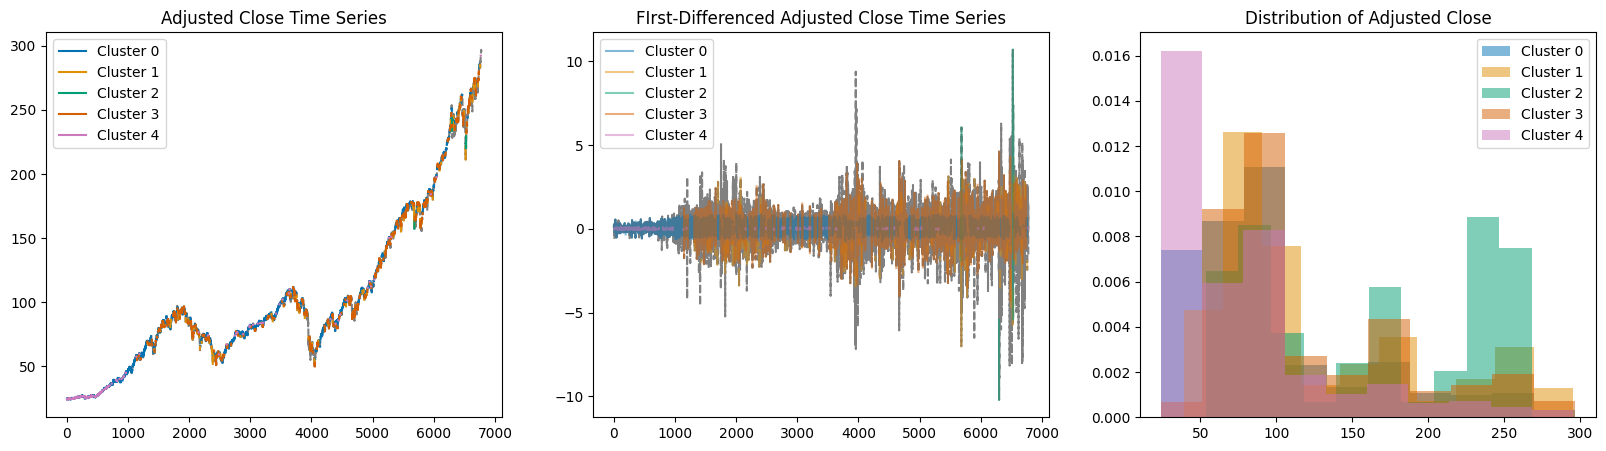

In [136]:
snp_df['best_mar_cluster'] = best_mar.greedy_assignment(best_mar.tau)
fig = plot_cluster_charts(snp_df, best_mar.n_components, 'best_mar_cluster')
plt.show()

In [144]:
def plot_individual_clusters(df:pd.DataFrame, target_component:int, n_components:int, label_col_name:str):
    fig, axes= plt.subplots(ncols=3, figsize=(20,5))
    colors = sns.color_palette("colorblind", n_components)
    
    target_data = df.copy()
    target_data.loc[target_data[label_col_name] != target_component] = np.nan
    axes[0].set_title("Adjusted Close Time Series")
    axes[0].plot(df['adj_close'], color='black', label='Underlying', linestyle='--', alpha=0.5)
    axes[0].scatter(x=target_data['adj_close'].index, y=target_data['adj_close'], color=colors[target_component], label=f'Cluster {target_component}', s=0.3) 
    axes[0].legend()
    
    axes[1].set_title('FIrst-Differenced Adjusted Close Time Series')
    axes[1].plot(df['first_diff'], color='black', label='Underlying', linestyle='--', alpha=0.5)
    axes[1].scatter(x=target_data['first_diff'].index, y=target_data['first_diff'], color=colors[target_component], label=f'Cluster {target_component}', s=0.3) 
    axes[1].legend()
    
    axes[2].set_title('Distribution of Adjusted Close')
    axes[2].hist(df['adj_close'], alpha=0.5, label='Underlying', density=True, color='black')
    axes[2].hist(target_data['adj_close'], alpha=0.5, label=f'Cluster {target_component}', density=True, color=colors[target_component])
    axes[2].legend()
    
    return fig

Based on the individual cluster charts, we note the following:
- **Cluster 0**: Stable market with small movements.
- **Cluster 1**: Moderate volatility regime, however it seems to overlap with Cluster 3.
- **Cluster 2**: Identifies spikes in the market, however this is very short-lived. Potentially could take a directional bet of a fall in volatility through an option strategy.
- **Cluster 3**: Same as Cluster 1.
- **Cluster 4**: Quiet market regime, with little to no movement.

Overall, the identified market regimes seem useful in the selection of which trading strategy to employ. However, one must explore other configurations to achieve the model that best aligns with the business purpose. 

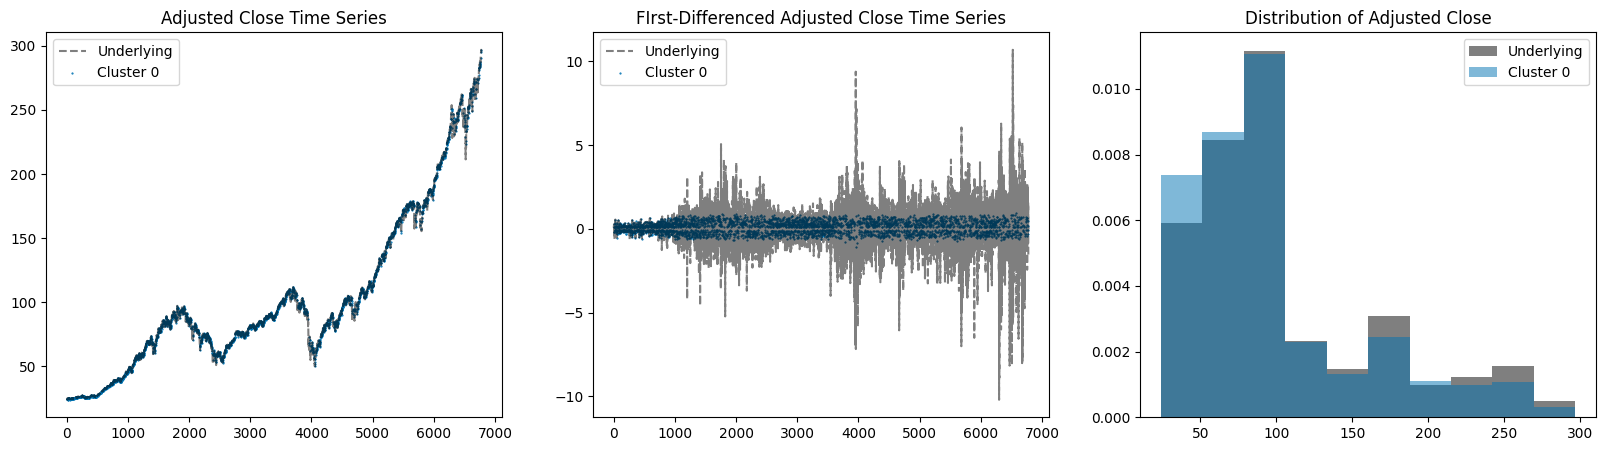

In [145]:
fig = plot_individual_clusters(snp_df, 0, best_mar.n_components, 'best_mar_cluster')
plt.show()

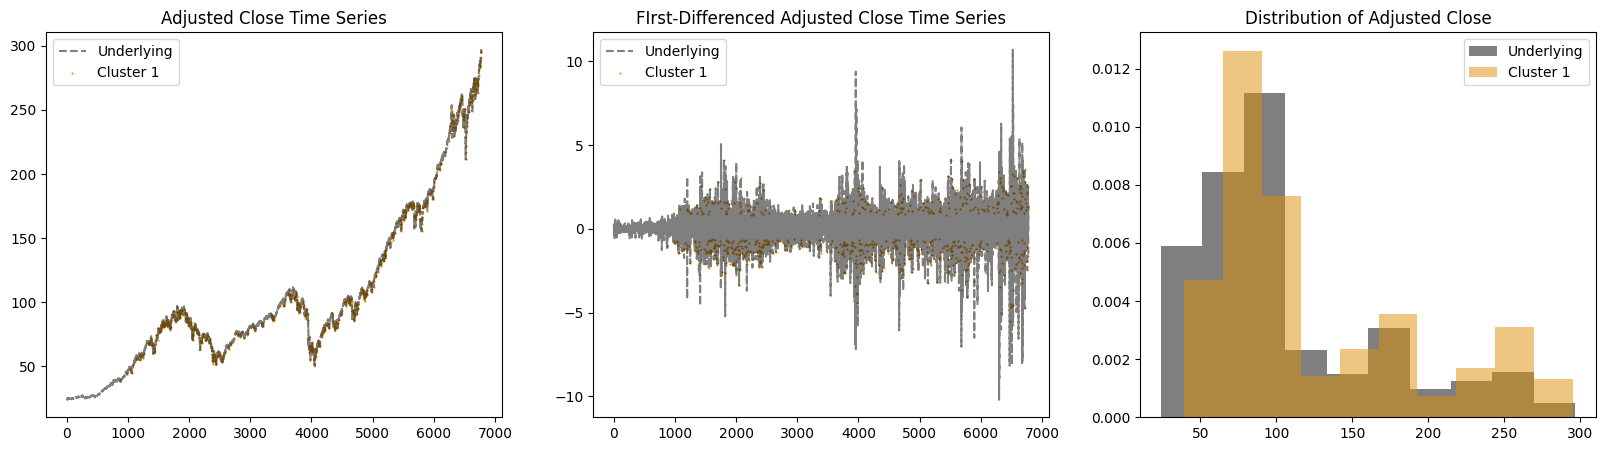

In [146]:
fig = plot_individual_clusters(snp_df, 1, best_mar.n_components, 'best_mar_cluster')
plt.show()

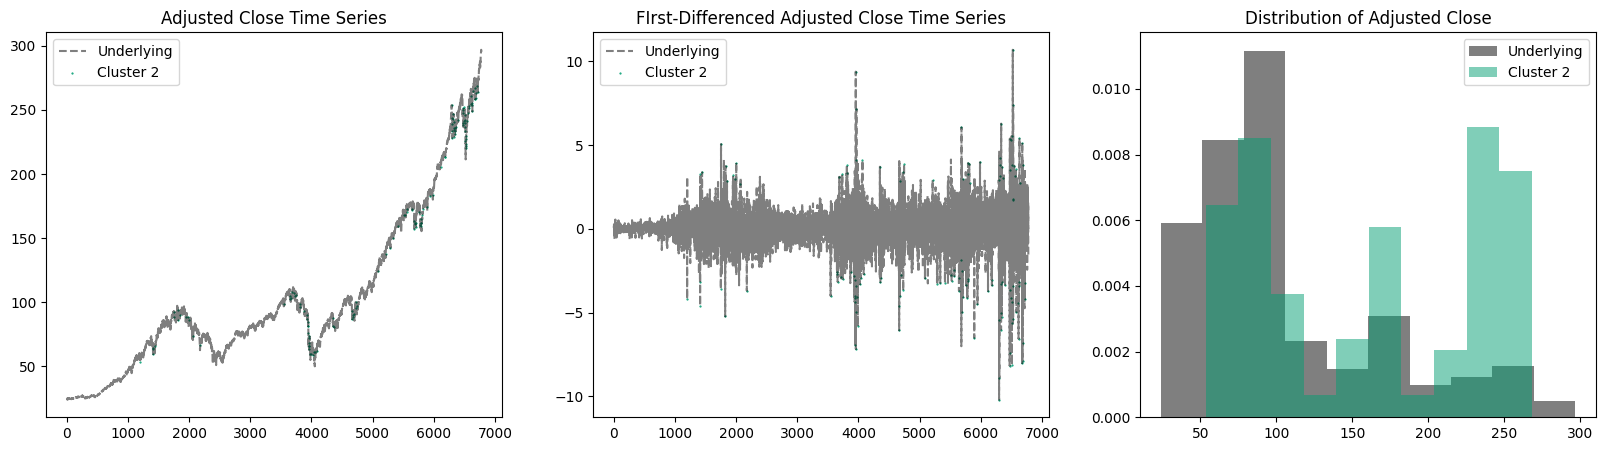

In [147]:
fig = plot_individual_clusters(snp_df, 2, best_mar.n_components, 'best_mar_cluster')
plt.show()

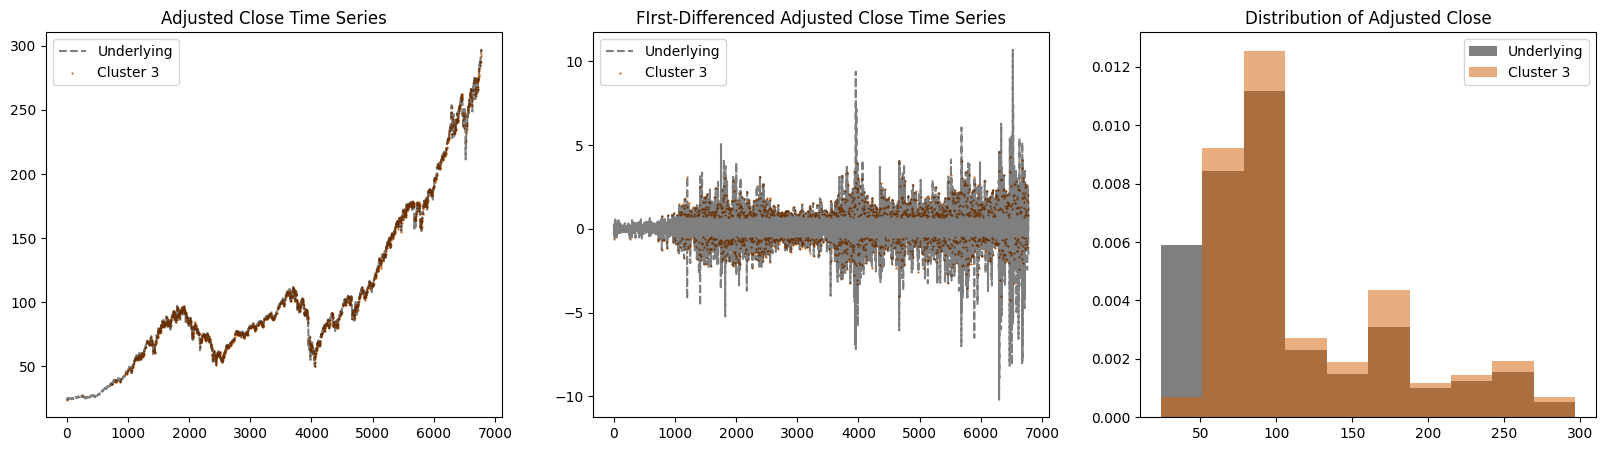

In [148]:
fig = plot_individual_clusters(snp_df, 3, best_mar.n_components, 'best_mar_cluster')
plt.show()

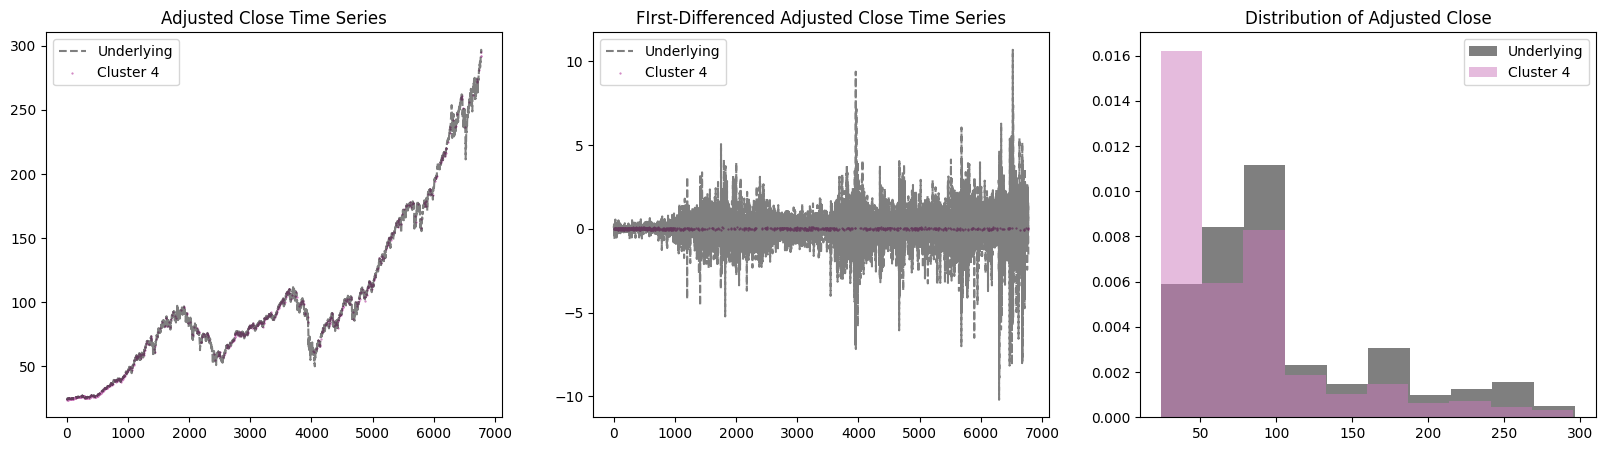

In [149]:
fig = plot_individual_clusters(snp_df, 4, best_mar.n_components, 'best_mar_cluster')
plt.show()